# Evaluation of the CCLM diurnal temperature cycle

Quick and dirty version - to be cleaned up and further developed. 


In [1]:
import valenspy as vp

import xarray as xr
from pathlib import Path
import cdo 
from yaml import safe_load
import os
from eval_functions import *
import warnings
from valenspy.inputconverter_functions import CCLM_to_CF

# Turn off all warnings
warnings.filterwarnings('ignore')

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

# postprocessing base directory 
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

src_path = Path("../src/valenspy")

variable = 'tas'


In [2]:

# reference dataset to compare to
model = 'CCLM'

# get lookup file for model
with open(src_path / "ancilliary_data" / Path(model+"_lookup.yml")) as file:
    mod_LOOKUP = safe_load(file)

# secondary list of variables to compare
# cloud characteristics (integrated cloud water, ice, graupel, snow and rain) (NOT YET IN CORDEX_VARIABLES list)
# ERA5-land: surface fluxes: latent heat, sensible heat

mod_var = mod_LOOKUP[variable]['mod_name']


### 1. Load CCLM diurnal cycle

In [12]:
# directory with experiments

experiments = ["EUR11_CO_TA_GC_TSO",
               "EUR11_CO_TT_GC_TSO", 
               "EUR11_CO_TT_EC_TSO", 
               "EUR11_NU_TE_GC_TSO", 
               "EUR11_NU_TT_GC_TSO", 
               "EUR11_NU_TT_EC_TSO"]
               
#experiments = [experiment]

file_identifier = 'diurnal_mean'

In [13]:

d_ds_mod_diurnalcycle = {}
for experiment in experiments: 

    # open COSMO data

    ds_mod_diurnalcycle = xr.open_dataset(f"/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/{experiment}/{mod_var}/{mod_var}_{file_identifier}_1995-1995_6-8.nc")

    # use inputconverter to do correct conversion
    ic = vp.InputConverter(CCLM_to_CF)
    ds_mod_diurnalcycle = ic.convert_input(ds_mod_diurnalcycle) # Convert the input to the correct format
    d_ds_mod_diurnalcycle[experiment] = ds_mod_diurnalcycle
#da_mod_diurnalcycle = ds_mod_diurnalcycle["T_2M"]


Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compl

In [5]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

## 2. Calculate diurnal cycle based on ERA5 data

In [6]:
ref_dataset='ERA5'
region = 'europe'
months_to_analyse = [6,7,8]
# start up input manager
manager = vp.InputManager(machine=machine)

# use input manager to load data, defined on settings above
ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="hourly",region=region, path_identifiers = ["-hourly-"])

ds_obs_timesel = ds_obs.sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))
if file_identifier== 'diurnal_mean':
    ds_obs_diurnalcycle =  ds_obs_timesel.groupby("time.hour").mean("time")
elif file_identifier == 'diurnal_max':
    # adapt (look at code Fien. )
    ds_obs_diurnalcycle =  ds_obs_timesel.groupby("time.hour").mean("time")
elif file_identifier == 'diurnal_mean':
    # adapt (look at code Fien. )
    ds_obs_diurnalcycle =  ds_obs_timesel.groupby("time.hour").mean("time")

da_obs_diurnalcycle = ds_obs_diurnalcycle[variable]
#da_obs_diurnalcycle = ds_obs_diurnalcycle[variable].rename({'hour':'time'})
#da_obs_diurnalcycle['time'] = ds_mod_diurnalcycle.time

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']


## 3. Do plotting

In [7]:
# do selection of individual points (do this in separate notebook.)
# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'channel'   : (-1.05, 50.14)
}
point_id = 'opwijk'
point_coord = d_point_coords[point_id]



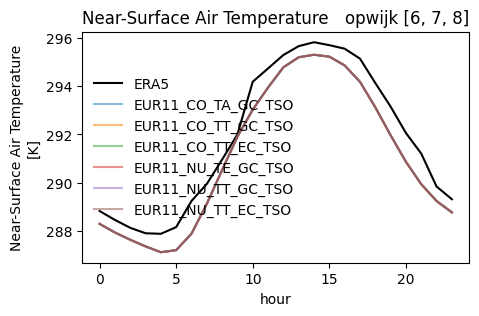

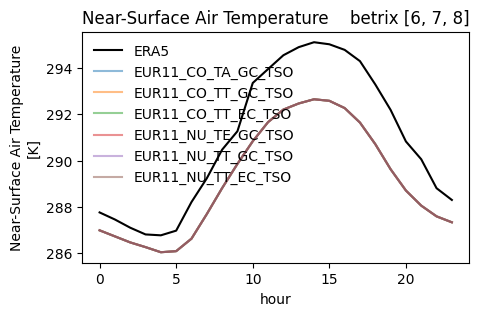

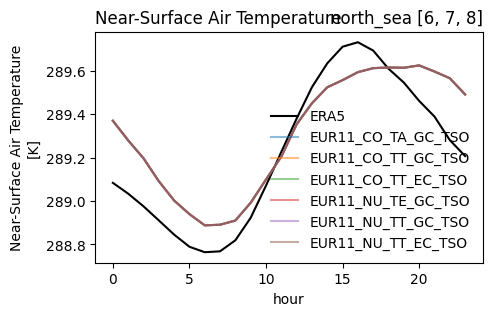

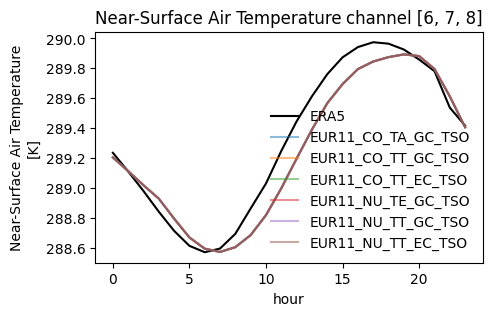

In [11]:

for point_id in d_point_coords: 
    point_coord = d_point_coords[point_id]

    da_obs_point = da_obs_diurnalcycle.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')

    coord_points_rotated = geo_to_rot(point_coord, ds_mod_diurnalcycle)
    
    # do plotting
    fig, ax = plt.subplots(figsize = (5,3))
    da_obs_point.plot(ax=ax, label = ref_dataset, color='k')

    for experiment in experiments: 
        d_ds_mod_diurnalcycle[experiment] = ds_mod_diurnalcycle
        da_mod_point = ds_mod_diurnalcycle[variable].sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest')
        da_mod_point = da_mod_point.rename({'time':'hour'})
        da_mod_point['hour'] = da_obs_point.hour
        
        da_mod_point.plot(ax=ax, label = experiment, alpha=0.5)

    ax.legend(frameon=False)

    ax.set_title(da_obs_point.attrs['long_name'], loc='left')
    ax.set_title(' ', loc='center')
    ax.set_title(f"{point_id} {str(months_to_analyse)}", loc='right'); 

